# Phase 8: Model Interpretation & Insights

In this notebook, we look "under the hood" of our Champion Model. We move beyond *accuracy* to *explainability*, using SHAP values to understand exactly why customers are churning.

### 1. Setup & Load Model

In [1]:
import pandas as pd
import numpy as np
import joblib
import shap
import sys
import os
import matplotlib.pyplot as plt

# Add src to path so we can import from our custom modules
sys.path.append(os.path.abspath('..'))

# RELOAD MODULE: This ensures updates to src/model_interpretation.py are loaded immediately
%load_ext autoreload
%autoreload 2

from src.config import PROCESSED_DATA_DIR, MODELS_DIR
# Import ALL necessary functions
from src.model_interpretation import (
    get_feature_importance,
    plot_feature_importance,
    calculate_shap_values,
    plot_shap_summary,
    plot_shap_dependence,
    explain_single_prediction
)

# Load Data (Use Train for interpretation to see what model learned)
X_train = pd.read_csv(PROCESSED_DATA_DIR / 'X_train.csv')

# We take a random sample of 500 rows for SHAP to speed up calculation
# (SHAP is computationally expensive on the full dataset)
X_sample = X_train.sample(500, random_state=42).reset_index(drop=True)
print(f"X_sample shape: {X_sample.shape}")

# Load Champion Model
model = joblib.load(MODELS_DIR / 'final_champion_tuned.joblib') 
print(f"Loaded Model: {type(model).__name__}")

X_sample shape: (500, 30)
Loaded Model: RandomForestClassifier


### 2. Global Feature Importance (Gini)
This tells us **which** features matter, but not **how** (positive/negative).

c:\Users\ishfa\datascience\customer-churn-prediction\src\model_interpretation.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(top_n), palette='viridis')


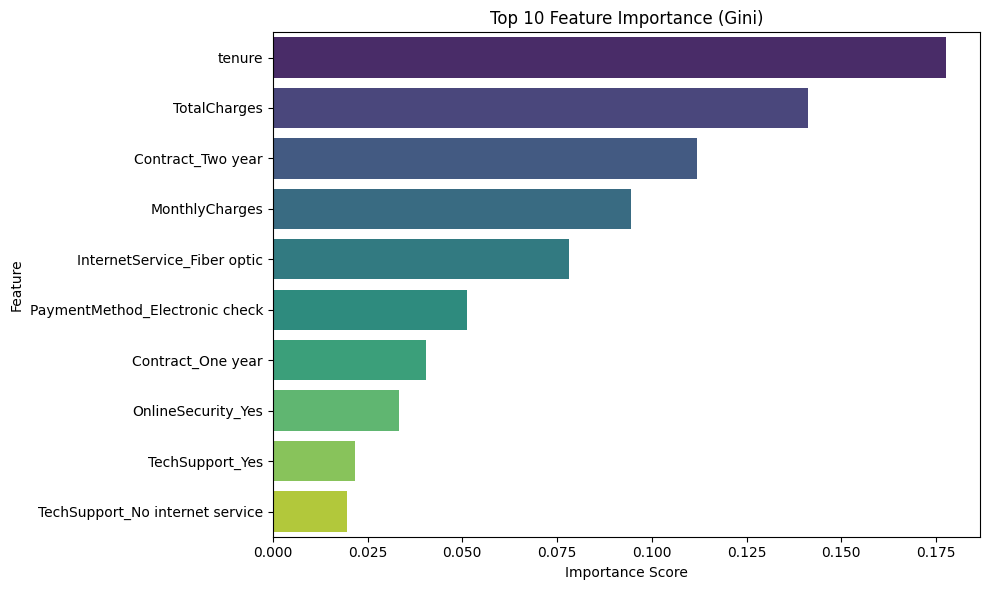

Insight: 'TotalCharges', 'Tenure', and 'Contract_Month-to-month' are usually the dominant drivers.


In [2]:
# Extract and Plot
imp_df = get_feature_importance(model, X_train.columns)
plot_feature_importance(imp_df)

print("Insight: 'TotalCharges', 'Tenure', and 'Contract_Month-to-month' are usually the dominant drivers.")

### 3. SHAP Summary Plot (The "Gold Standard")
This shows both importance AND direction.
* **Red dots:** High feature value (e.g., High Monthly Charges).
* **Blue dots:** Low feature value.
* **X-axis:** Impact on Churn Probability (Right = Increases Risk).

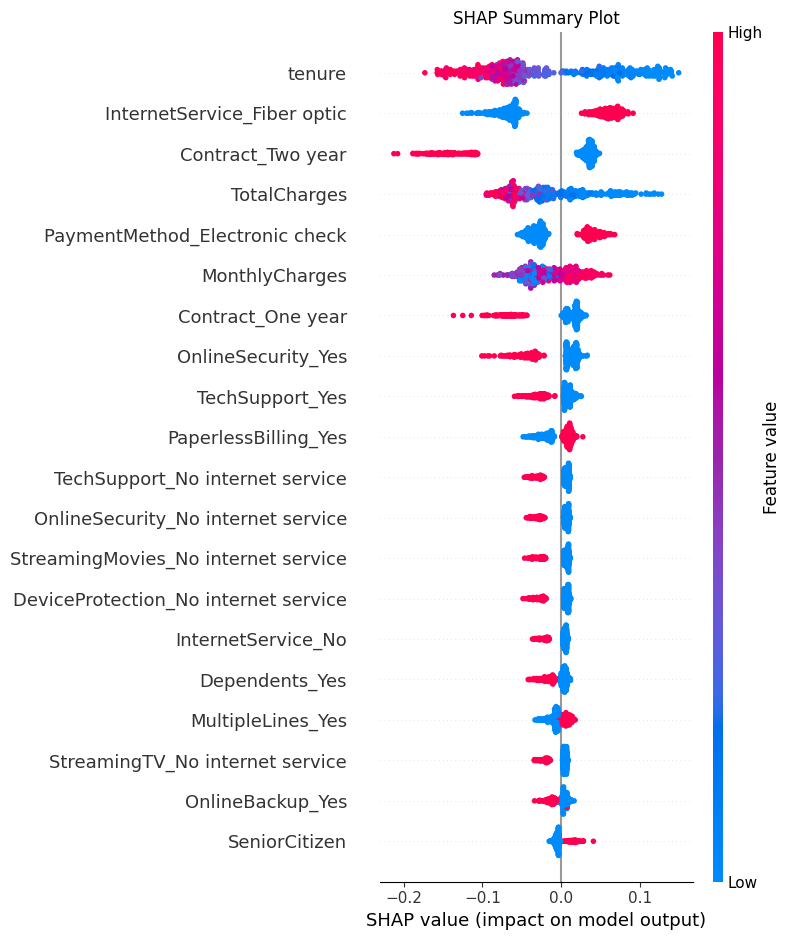

In [3]:
# Calculate SHAP
# This returns the explainer object AND the shap_values data
explainer, shap_values = calculate_shap_values(model, X_sample)

# Plot Summary
plot_shap_summary(shap_values, X_sample)

**Interpretation Guide:**
* Look at **Contract_Month-to-month**: Is the Red side (Yes) on the right? (Means Month-to-month INCREASES churn).
* Look at **Tenure**: Is the Blue side (Low tenure) on the right? (Means New customers are HIGH risk).
* Look at **MonthlyCharges**: Are Red dots (High charges) pushing probability up?

### 4. Deep Dive: Dependence Plots
Let's analyze the non-linear relationship of **Tenure** and **Monthly Charges**.

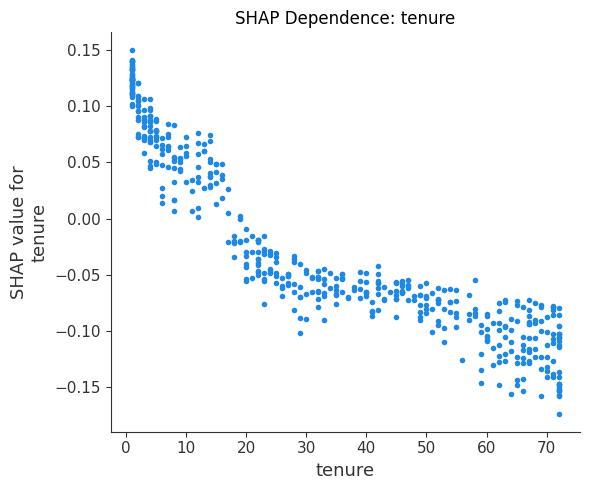

Insight: Notice how risk drops sharply after ~12 months.


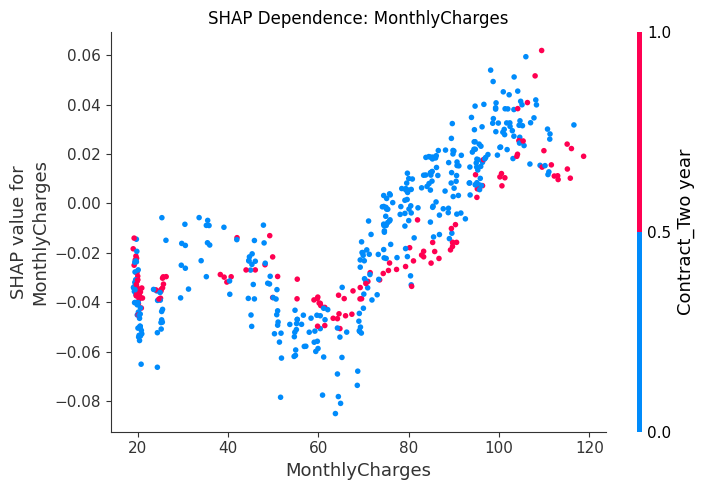

Insight: High charges are generally risky, but see how being on a Two Year contract (Red dots) changes that risk.


In [4]:
# Tenure Dependence
plot_shap_dependence(shap_values, X_sample, 'tenure', interaction_feature=None)
print("Insight: Notice how risk drops sharply after ~12 months.")

# Monthly Charges Dependence
# FIX: 'Contract_Month-to-month' was dropped during encoding, so we use 'Contract_Two year'
# or 'InternetService_Fiber optic' as the interaction feature instead.
plot_shap_dependence(
    shap_values, 
    X_sample, 
    'MonthlyCharges', 
    interaction_feature='Contract_Two year'
)
print("Insight: High charges are generally risky, but see how being on a Two Year contract (Red dots) changes that risk.")

### 5. Individual Explanations (Local Interpretability)
Let's explain why a **specific high-risk customer** was flagged. This is useful for Customer Support dashboards.

Explaining Customer #24 (Churn Probability: 95.00%)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
24,1,1.0,93.55,93.55,True,False,False,True,False,True,...,False,True,False,True,False,False,True,False,True,False


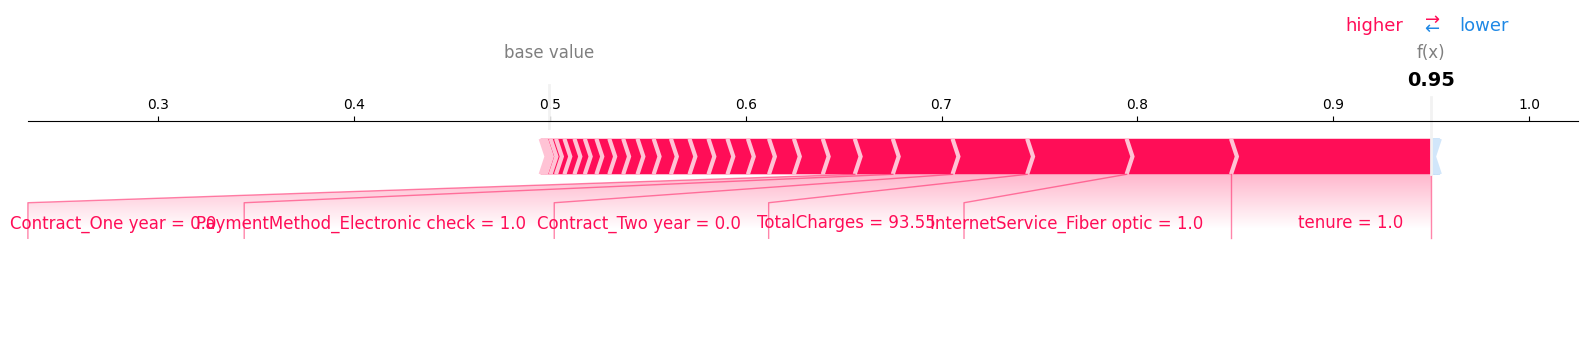

In [5]:
# Pick a high-risk customer from our sample
# We predict proba for the sample to find a risky one
probs = model.predict_proba(X_sample)[:, 1]
risky_idx = np.argmax(probs) # Index of highest churn probability
risky_customer = X_sample.iloc[[risky_idx]]

print(f"Explaining Customer #{risky_idx} (Churn Probability: {probs[risky_idx]:.2%})")
display(risky_customer)

# Generate Force Plot
explain_single_prediction(explainer, risky_customer)

### 6. Summary of Key Business Insights
Based on the SHAP analysis, here are the actionable findings for the final report:

1.  **The "Month-to-Month" Trap:** This is the single strongest predictor. The SHAP summary shows a massive positive impact on churn risk. *Recommendation: Incentivize 1-year contracts.*
2.  **The "First Year" Danger Zone:** Tenure has a diminishing return. The risk is extremely high for months 0-12, then plateaus. *Recommendation: intense onboarding for first 6 months.*
3.  **Fiber Optic Issues:** Being on Fiber Optic (often associated with higher `MonthlyCharges`) consistently pushes risk up. *Recommendation: Investigate technical stability of Fiber service.*
4.  **Electronic Check:** This payment method is uniquely correlated with higher churn, visible in the Gini importance.